## Imports

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import glob
import os
import shutil
from PIL import Image, ImageFilter
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, UpSampling2D,\
    Dense, Layer, Reshape, InputLayer, Flatten, Input, MaxPooling2D
from alibi_detect.od import OutlierAE, OutlierVAE
from alibi_detect.utils.visualize import plot_instance_score, plot_feature_outlier_image
from sklearn.metrics import roc_auc_score
import timm
import torch
from tqdm import tqdm
from typing import Tuple
from torch import tensor
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader
from pathlib import Path
import sys


## Preprocessing

In [27]:
def img_to_np(path, resize = True):  
    img_array = []
    fpaths = glob.glob(path, recursive=True)
    for fname in fpaths:
        img = Image.open(fname).convert("RGB")
        if(resize): img = img.resize((64,64))
        img_array.append(np.asarray(img))
    images = np.array(img_array)
    return images
  
path_train = "./metal_nut/train/**/*.*"
path_test = "./metal_nut/test/**/*.*"

train = img_to_np(path_train)
test = img_to_np(path_test)
train = train.astype('float32') / 255.
test = test.astype('float32') / 255.
print("completed")

completed


In [8]:
print(train.shape)

(220, 64, 64, 3)


## Auto-encoder

In [28]:
encoding_dim = 1024
dense_dim = [8, 8, 128]

encoder_net = tf.keras.Sequential(
  [
      InputLayer(input_shape=train[0].shape),
      Conv2D(64, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2D(128, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2D(512, 4, strides=2, padding='same', activation=tf.nn.relu),
      Flatten(),
      Dense(encoding_dim,)
  ])

decoder_net = tf.keras.Sequential(
  [
      InputLayer(input_shape=(encoding_dim,)),
      Dense(np.prod(dense_dim)),
      Reshape(target_shape=dense_dim),
      Conv2DTranspose(256, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2DTranspose(64, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2DTranspose(3, 4, strides=2, padding='same', activation='sigmoid')
  ])

od = OutlierAE( threshold = 0.001,
                encoder_net=encoder_net,
                decoder_net=decoder_net)

adam = tf.keras.optimizers.Adam(lr=1e-4)

od.fit(train, epochs=20, verbose=True,
       optimizer = adam)

od.infer_threshold(test, threshold_perc=95)

preds = od.predict(test, outlier_type='instance',
            return_instance_score=True,
            return_feature_score=True)

/home/ananthan2k/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


4/4 [=] - 4s 1s/step - loss_ma: 0.0118


In [29]:
for i, fpath in enumerate(glob.glob(path_test)):
    if(preds['data']['is_outlier'][i] == 1):
        source = fpath
        shutil.copy(source, 'img\\')
        
filenames = [os.path.basename(x) for x in glob.glob(path_test, recursive=True)]

dict1 = {'Filename': filenames,
     'instance_score': preds['data']['instance_score'],
     'is_outlier': preds['data']['is_outlier']}
     
df = pd.DataFrame(dict1)
df_outliers = df[df['is_outlier'] == 1]

print(df_outliers)

   Filename  instance_score  is_outlier
3   009.png        0.014233           1
5   012.png        0.016176           1
21  007.png        0.014725           1
41  010.png        0.016619           1
45  000.png        0.014198           1
53  004.png        0.015941           1


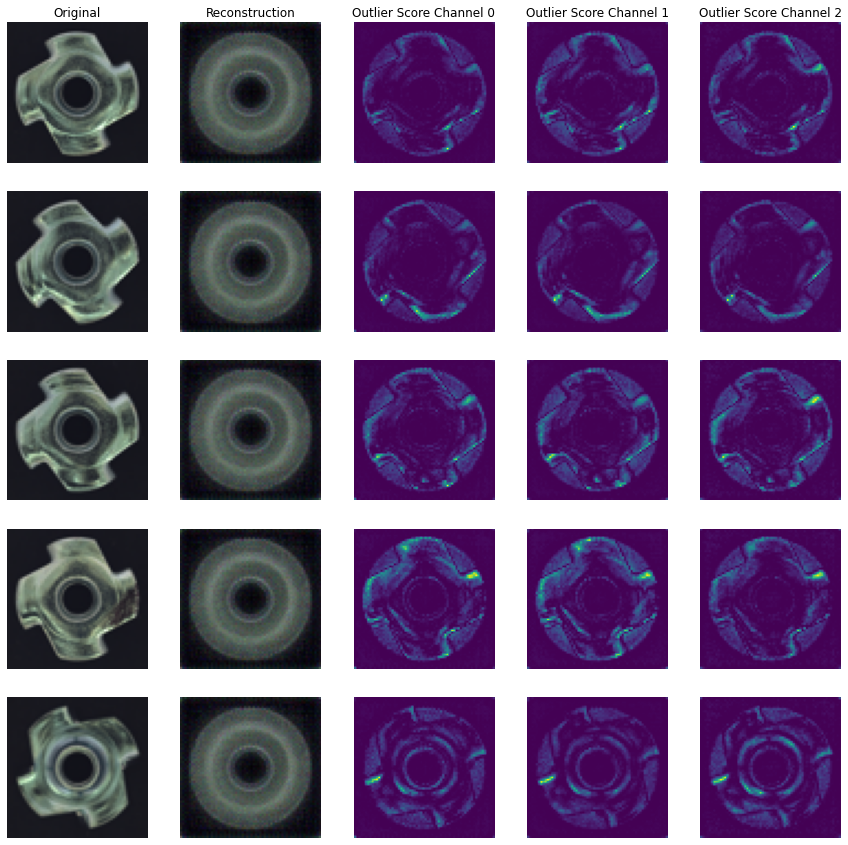

In [30]:
recon = od.ae(test).numpy()

plot_feature_outlier_image(preds, test, 
                           X_recon=recon,  
                           max_instances=5,
                           outliers_only=True,
                           figsize=(15,15))

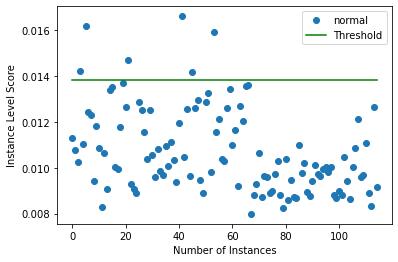

In [31]:
new_train = train[:115]
target = np.zeros(new_train.shape[0],).astype(int)  # all normal CIFAR10 training instances
labels = ['normal', 'outlier']
plot_instance_score(preds, target, labels, od.threshold)

## Variational Auto-encoder

In [32]:
## encoding layer
latent_dim = 1024
dense_dim = [8, 8, 128]

encoder_net = tf.keras.Sequential(
  [
      InputLayer(input_shape=train[0].shape),
      Conv2D(64, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2D(128, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2D(512, 4, strides=2, padding='same', activation=tf.nn.relu),
      Flatten(),
      Dense(latent_dim,)
  ])

decoder_net = tf.keras.Sequential(
  [
      InputLayer(input_shape=(latent_dim,)),
      Dense(np.prod(dense_dim)),
      Reshape(target_shape=dense_dim),
      Conv2DTranspose(256, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2DTranspose(64, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2DTranspose(3, 4, strides=2, padding='same', activation='sigmoid')
  ])

od = OutlierVAE(
    threshold=0.001,
    encoder_net=encoder_net,
    decoder_net=decoder_net,
    latent_dim=1024,
    samples=10
)

adam = tf.keras.optimizers.Adam(learning_rate=1e-4)

od_training = od.fit(
    train,
    epochs=20,
    verbose=True,
    optimizer=adam
)
od.infer_threshold(
    test, threshold_perc=95
)

preds = od.predict(
    test,
    outlier_type='instance',
    return_feature_score=True,
    return_instance_score=True
)

4/4 [=] - 5s 1s/step - loss_ma: 2670.6120


In [33]:
for i, fpath in enumerate(glob.glob(path_test)):
    if(preds['data']['is_outlier'][i] == 1):
        source = fpath
        shutil.copy(source, 'img\\')
        
filenames = [os.path.basename(x) for x in glob.glob(path_test, recursive=True)]

dict1 = {'Filename': filenames,
     'instance_score': preds['data']['instance_score'],
     'is_outlier': preds['data']['is_outlier']}
     
df = pd.DataFrame(dict1)
df_outliers = df[df['is_outlier'] == 1]

print(df_outliers)

   Filename  instance_score  is_outlier
3   009.png        0.013990           1
5   012.png        0.015837           1
21  007.png        0.014505           1
41  010.png        0.016199           1
45  000.png        0.013953           1
53  004.png        0.015613           1


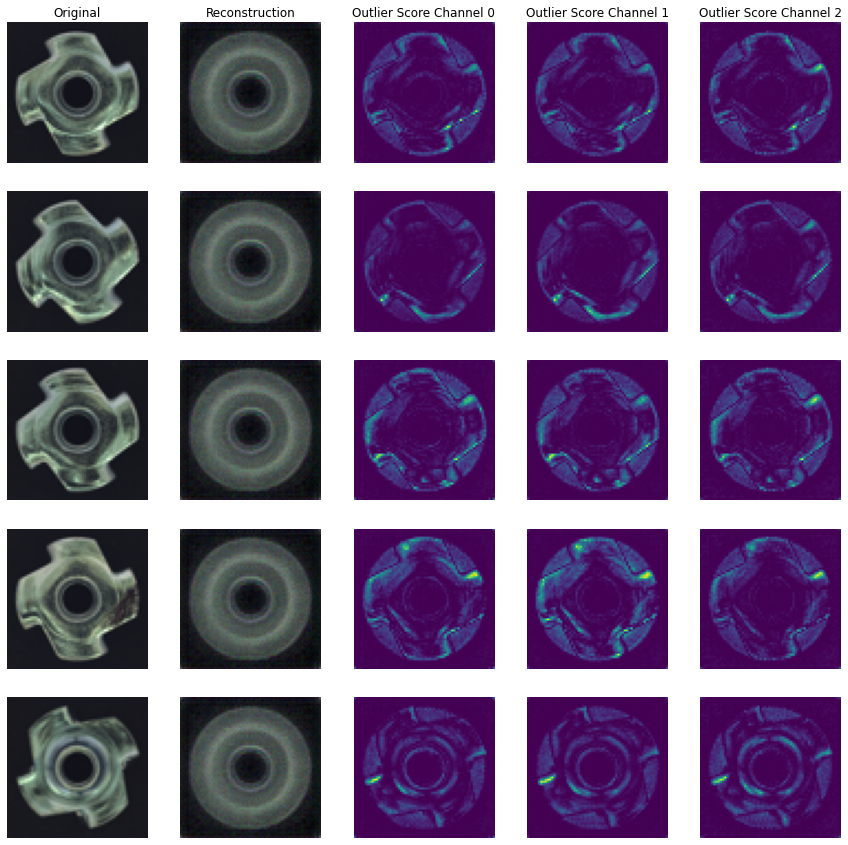

In [34]:
recon = od.vae(test).numpy()

plot_feature_outlier_image(preds, test, 
                           X_recon=recon,  
                           max_instances=5,
                           outliers_only=True,
                           figsize=(15,15))

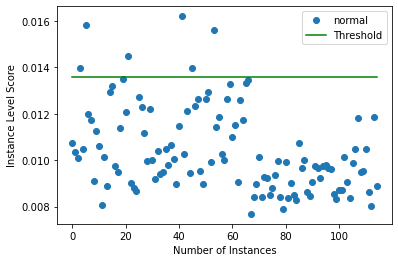

In [35]:
new_train = train[:115]
target = np.zeros(new_train.shape[0],).astype(int)  # all normal CIFAR10 training instances
labels = ['normal', 'outlier']
plot_instance_score(preds, target, labels, od.threshold)

## SPADE(KNN based outlier detection)

In [13]:
DATASETS_PATH = Path(".")
IMAGENET_MEAN = tensor([.485, .456, .406])
IMAGENET_STD = tensor([.229, .224, .225])

In [14]:
def mvtec_classes():
    return ["metal_nut"]

In [15]:
class MVTecDataset:
    def __init__(self, cls : str, size : int = 224):
        self.cls = cls
        self.size = size
        
        self.train_ds = MVTecTrainDataset(cls, size)
        self.test_ds = MVTecTestDataset(cls, size)
        
    def get_datasets(self):
        return self.train_ds, self.test_ds

    def get_dataloaders(self):
        return DataLoader(self.train_ds), DataLoader(self.test_ds)

In [16]:
class MVTecTrainDataset(ImageFolder):
    def __init__(self, cls : str, size : int):
        super().__init__(
            root= DATASETS_PATH / cls / "train",
            transform=transforms.Compose([
                transforms.Resize(256, interpolation=transforms.InterpolationMode.BICUBIC),
                transforms.CenterCrop(size),
                transforms.ToTensor(),
                transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
            ])
        )
        self.cls = cls
        self.size = size


In [17]:
class MVTecTestDataset(ImageFolder):
    def __init__(self, cls : str, size : int):
        super().__init__(
            root= DATASETS_PATH / cls / "test",
            transform=transforms.Compose([
                transforms.Resize(256, interpolation=transforms.InterpolationMode.BICUBIC),
                transforms.CenterCrop(size),
                transforms.ToTensor(),
                transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
            ]),
            target_transform=transforms.Compose([
                transforms.Resize(256, interpolation=transforms.InterpolationMode.NEAREST
                ),
                transforms.CenterCrop(size),
                transforms.ToTensor(),
            ]),
        )
        self.cls = cls
        self.size = size
    
    def __getitem__(self, index):
        path, _ = self.samples[index]
        sample = self.loader(path)
        
        if "good" in path:
            target = Image.new('L', (self.size, self.size))
            sample_class = 0
        else:
            target_path = path.replace("test", "ground_truth")
            target_path = target_path.replace(".png", "_mask.png")
            target = self.loader(target_path)
            sample_class = 1

        if self.transform is not None:
            sample = self.transform(sample)
        if self.target_transform is not None:
            target = self.target_transform(target)

        return sample, target[:1], sample_class

In [18]:
class KNNExtractor(torch.nn.Module):
	def __init__(
		self,
		backbone_name : str = "resnet50",
		out_indices : Tuple = None,
		pool_last : bool = False,
	):
		super().__init__()

		self.feature_extractor = timm.create_model(
			backbone_name,
			out_indices=out_indices,
			features_only=True,
			pretrained=True,
		)
		for param in self.feature_extractor.parameters():
			param.requires_grad = False
		self.feature_extractor.eval()
		
		self.pool = torch.nn.AdaptiveAvgPool2d(1) if pool_last else None
		self.backbone_name = backbone_name # for results metadata
		self.out_indices = out_indices

		self.device = "cuda" if torch.cuda.is_available() else "cpu"
		self.feature_extractor = self.feature_extractor.to(self.device)
			
	def __call__(self, x: tensor):
		with torch.no_grad():
			feature_maps = self.feature_extractor(x.to(self.device))
		feature_maps = [fmap.to("cpu") for fmap in feature_maps]
		if self.pool:
			# spit into fmaps and z
			return feature_maps[:-1], self.pool(feature_maps[-1])
		else:
			return feature_maps

	def fit(self, _: DataLoader):
		raise NotImplementedError

	def predict(self, _: tensor):
		raise NotImplementedError

	def evaluate(self, test_dl: DataLoader) -> Tuple[float, float]:
		"""Calls predict step for each test sample."""
		image_preds = []
		image_labels = []
		pixel_preds = []
		pixel_labels = []

		for sample, mask, label in tqdm(test_dl, **get_tqdm_params()):
			z_score, fmap = self.predict(sample)
			
			image_preds.append(z_score.numpy())
			image_labels.append(label)
			
			pixel_preds.extend(fmap.flatten().numpy())
			pixel_labels.extend(mask.flatten().numpy())
			
		image_preds = np.stack(image_preds)

		image_rocauc = roc_auc_score(image_labels, image_preds)
		pixel_rocauc = roc_auc_score(pixel_labels, pixel_preds)

		return image_rocauc, pixel_rocauc

	def get_parameters(self, extra_params : dict = None) -> dict:
		return {
			"backbone_name": self.backbone_name,
			"out_indices": self.out_indices,
			**extra_params,
		}

In [19]:
class SPADE(KNNExtractor):
	def __init__(
		self,
		k: int = 5,
		backbone_name: str = "resnet18",
	):
		super().__init__(
			backbone_name=backbone_name,
			out_indices=(1,2,3,-1),
			pool_last=True,
		)
		self.k = k
		self.image_size = 224
		self.z_lib = []
		self.feature_maps = []
		self.threshold_z = None
		self.threshold_fmaps = None
		self.blur = GaussianBlur(4)

	def fit(self, train_dl):
		for sample, _ in tqdm(train_dl, **get_tqdm_params()):
			feature_maps, z = self(sample)

			# z vector
			self.z_lib.append(z)

			# feature maps
			if len(self.feature_maps) == 0:
				for fmap in feature_maps:
					self.feature_maps.append([fmap])
			else:
				for idx, fmap in enumerate(feature_maps):
					self.feature_maps[idx].append(fmap)

		self.z_lib = torch.vstack(self.z_lib)
		
		for idx, fmap in enumerate(self.feature_maps):
			self.feature_maps[idx] = torch.vstack(fmap)

	def predict(self, sample):
		feature_maps, z = self(sample)

		distances = torch.linalg.norm(self.z_lib - z, dim=1)
		values, indices = torch.topk(distances.squeeze(), self.k, largest=False)

		z_score = values.mean()

		# Build the feature gallery out of the k nearest neighbours.
		# The authors migh have concatenated all features maps first, then check the minimum norm per pixel.
		# Here, we check for the minimum norm first, then concatenate (sum) in the final layer.
		scaled_s_map = torch.zeros(1,1,self.image_size,self.image_size)
		for idx, fmap in enumerate(feature_maps):
			nearest_fmaps = torch.index_select(self.feature_maps[idx], 0, indices)
			# min() because kappa=1 in the paper
			s_map, _ = torch.min(torch.linalg.norm(nearest_fmaps - fmap, dim=1), 0, keepdims=True)
			scaled_s_map += torch.nn.functional.interpolate(
				s_map.unsqueeze(0), size=(self.image_size,self.image_size), mode='bilinear'
			)

		scaled_s_map = self.blur(scaled_s_map)
		
		return z_score, scaled_s_map

	def get_parameters(self):
		return super().get_parameters({
			"k": self.k,
		})

In [24]:
class GaussianBlur:
    def __init__(self, radius : int = 4):
        self.radius = radius
        self.unload = transforms.ToPILImage()
        self.load = transforms.ToTensor()
        self.blur_kernel = ImageFilter.GaussianBlur(radius=4)

    def __call__(self, img):
        map_max = img.max()
        final_map = self.load(
            self.unload(img[0]/map_max).filter(self.blur_kernel)
        )*map_max
        return final_map
    
TQDM_PARAMS = {
	"file" : sys.stdout,
	"bar_format" : "   {l_bar}{bar:10}{r_bar}{bar:-10b}",
}

def get_tqdm_params():
    return TQDM_PARAMS

In [25]:
model = SPADE(
                k=50,
                backbone_name="wide_resnet50_2",
            )
train_ds, test_ds = MVTecDataset("metal_nut").get_dataloaders()
model.fit(train_ds)
image_rocauc, pixel_rocauc = model.evaluate(test_ds)

     1%|          | 1/115 [00:00<00:22,  5.07it/s]

/home/ananthan2k/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


   100%|██████████| 115/115 [00:20<00:00,  5.57it/s]


In [26]:
results = {}
results['bottle'] = [float(image_rocauc), float(pixel_rocauc)]
        
image_results = [v[0] for _, v in results.items()]
average_image_roc_auc = sum(image_results)/len(image_results)
image_results = [v[1] for _, v in results.items()]
average_pixel_roc_auc = sum(image_results)/len(image_results)

total_results = {
        "per_class_results": results,
        "average image rocauc": average_image_roc_auc,
        "average pixel rocauc": average_pixel_roc_auc,
        "model parameters": model.get_parameters(),
    }
print(total_results)

{'per_class_results': {'bottle': [0.7458455522971652, 0.9614453786197061]}, 'average image rocauc': 0.7458455522971652, 'average pixel rocauc': 0.9614453786197061, 'model parameters': {'backbone_name': 'wide_resnet50_2', 'out_indices': (1, 2, 3, -1), 'k': 50}}
